# Computing with shapes of landmarks in Kendall shape spaces

Lead author: Nina Miolane.

In this tutorial, we show how to use geomstats to perform a shape data analysis. Specifically, we aim to study the difference between two groups of data:
- optical nerve heads that correspond to normal eyes,
- optical nerve heads that correspond to glaucoma eyes.

We wish to investigate if there is a difference in these two groups, and if this difference is a difference in sizes of the optical nerve heads, or a difference in shapes (where the size has been quotiented out).

<img src="figures/optic_nerves.png" />

In [1]:
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import geomstats.backend as gs
import geomstats.datasets.utils as data_utils
from geomstats.geometry.pre_shape import PreShapeSpace

%matplotlib inline

INFO: Using numpy backend


We import the dataset of the optical nerve heads from 22 images of Rhesus monkeys’ eyes (11 monkeys), available in [[PE2015]](#References). 

For each monkey, an experimental glaucoma was introduced in one eye, while the second
eye was kept as control. One seeks to observe differences between the glaucoma and the
control eyes. On each image, 5 anatomical landmarks were recorded: 
- 1st landmark: superior aspect of the retina, 
- 2nd landmark: side of the retina closest to the temporal bone of the skull,
- 3rd landmark: nose side of the retina, 
- 4th landmark: inferior point,
- 5th landmark: optical nerve head deepest point.

Label 0 refers to a normal eye, and Label 1 to an eye with glaucoma.

In [2]:
nerves, labels, monkeys = data_utils.load_optical_nerves()
print(nerves.shape)
print(labels)
print(monkeys)

(22, 5, 3)
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
[ 0  0  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10]


We extract the landmarks' sets corresponding to the two eyes' nerves of the first monkey, with their corresponding labels.

In [3]:
two_nerves = nerves[monkeys == 0]
print(two_nerves.shape)

two_labels = labels[monkeys == 0]
print(two_labels)

(2, 5, 3)
[0 1]


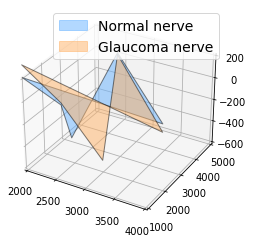

In [4]:
label_to_str = {0: "Normal nerve", 1: "Glaucoma nerve"}
label_to_color = {
    0: (102 / 255, 178 / 255, 255 / 255, 1.0),
    1: (255 / 255, 178 / 255, 102 / 255, 1.0),
}

fig = plt.figure()
ax = plt.axes(projection="3d")
ax.set_xlim((2000, 4000))
ax.set_ylim((1000, 5000))
ax.set_zlim((-600, 200))

for nerve, label in zip(two_nerves, two_labels):
    x = nerve[:, 0]
    y = nerve[:, 1]
    z = nerve[:, 2]

    verts = [list(zip(x, y, z))]

    poly = Poly3DCollection(verts, alpha=0.5)
    color = label_to_color[int(label)]
    poly.set_color(colors.rgb2hex(color))
    poly.set_edgecolor("k")
    ax.add_collection3d(poly)

patch_0 = mpatches.Patch(color=label_to_color[0], label=label_to_str[0], alpha=0.5)
patch_1 = mpatches.Patch(color=label_to_color[1], label=label_to_str[1], alpha=0.5)
plt.legend(handles=[patch_0, patch_1], prop={"size": 14})
plt.show()

We first try to detect if there are two groups of optical nerve heads, based on the 3D coordinates of the landmarks sets.

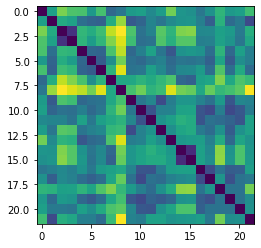

In [5]:
from geomstats.geometry.euclidean import Euclidean

nerves_vec = nerves.reshape(22, -1)

eucl = Euclidean(dim=nerves_vec.shape[-1])

eucl_dist = eucl.metric.dist_pairwise(nerves_vec)

plt.figure()
plt.imshow(eucl_dist);

We do not see any two clear clusters.

We want to investigate if there is a difference between these two groups of shapes - normal nerve versus glaucoma nerve - or if the main difference is merely relative to the global size of the landmarks' sets.

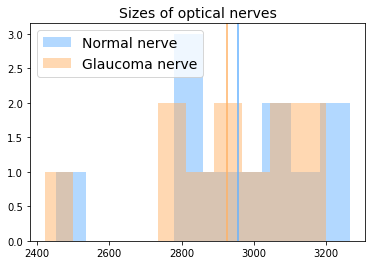

In [6]:
m_ambient = 3
k_landmarks = 5

preshape = PreShapeSpace(m_ambient=m_ambient, k_landmarks=k_landmarks)
matrices_metric = preshape.embedding_space.metric

sizes = matrices_metric.norm(preshape.center(nerves))

plt.figure(figsize=(6, 4))
for label, col in label_to_color.items():
    label_sizes = sizes[labels == label]
    plt.hist(label_sizes, color=col, label=label_to_str[label], alpha=0.5, bins=10)
    plt.axvline(gs.mean(label_sizes), color=col)
plt.legend(fontsize=14)
plt.title("Sizes of optical nerves", fontsize=14);

The vertical lines represent the sample mean of each group (normal/glaucoma).

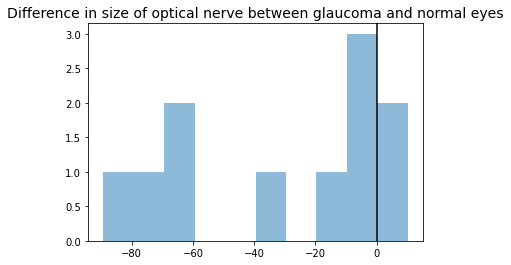

In [7]:
plt.figure(figsize=(6, 4))
plt.hist(sizes[labels == 1] - sizes[labels == 0], alpha=0.5)
plt.axvline(0, color="black")
plt.title(
    "Difference in size of optical nerve between glaucoma and normal eyes", fontsize=14
);

We perform a hypothesis test, testing if the two samples of sizes have the same average. We use the t-test for related samples, since the sample elements are paired: two eyes for each monkey.

In [8]:
from scipy import stats

signif_level = 0.05

tstat, pvalue = stats.ttest_rel(sizes[labels == 0], sizes[labels == 1])
print(pvalue < signif_level)

True


There is a significative difference, in optical nerve eyes' sizes, between the glaucoma and normal eye.

We want to investigate if there is a difference in shapes, where the size component has been quotiented out. 

We project the data to the Kendall pre-shape space, which:
- centers the nerve landmark sets so that they share the same barycenter,
- normalizes the sizes of the landmarks' sets to 1.

In [9]:
nerves_preshape = preshape.projection(nerves)
print(nerves_preshape.shape)
print(preshape.belongs(nerves_preshape))
print(gs.isclose(matrices_metric.norm(nerves_preshape), 1.0))

(22, 5, 3)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]


In order to quotient out the 3D orientation component, we align the landmark sets in the preshape space. 

In [10]:
preshape.equip_with_group_action('rotations')
preshape.equip_with_quotient_structure()

base_point = nerves_preshape[0]

nerves_shape = preshape.fiber_bundle.align(point=nerves_preshape, base_point=base_point)

The Kendall metric is a Riemannian metric that takes this alignment into account. It corresponds to the metric of the Kendall shape space, which is the manifold defined as the preshape space quotient by the action of the rotation in m_ambient dimensions, here in 3 dimensions.

In [11]:
kendall_metric = preshape.quotient.metric

We can use it to perform a tangent PCA in the Kendall shape space, and determine if we see a difference in the shapes of the optical nerves.

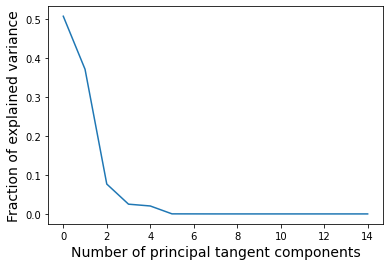

In [12]:
from geomstats.learning.pca import TangentPCA

tpca = TangentPCA(kendall_metric)
tpca.fit(nerves_shape)

plt.plot(tpca.explained_variance_ratio_)
plt.xlabel("Number of principal tangent components", size=14)
plt.ylabel("Fraction of explained variance", size=14);

Two principal components already describe around 60% of the variance. We plot the data projected in the tangent space defined by these two principal components.

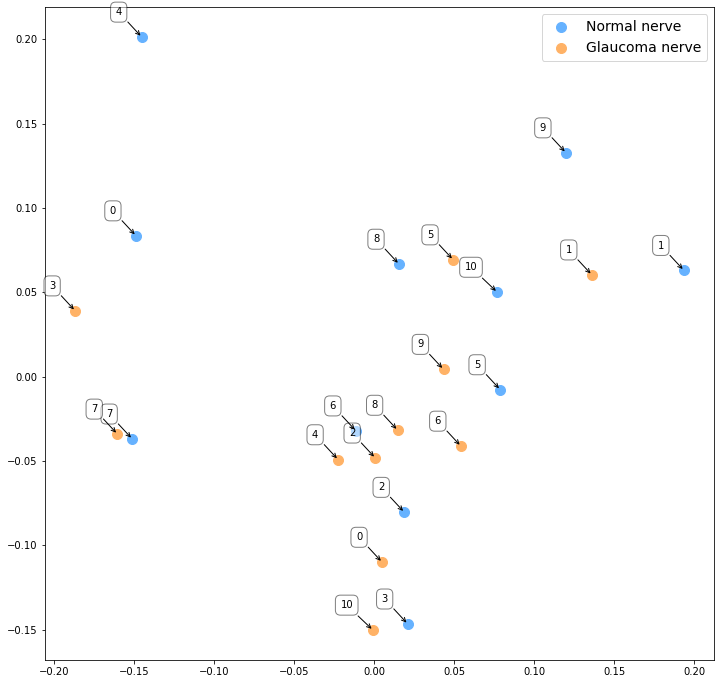

In [13]:
X = tpca.transform(nerves_shape)

plt.figure(figsize=(12, 12))

for label, col in label_to_color.items():
    mask = labels == label
    plt.scatter(X[mask, 0], X[mask, 1], color=col, s=100, label=label_to_str[label])
plt.legend(fontsize=14)

for label, x, y in zip(monkeys, X[:, 0], X[:, 1]):
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(-20, 20),
        textcoords="offset points",
        ha="right",
        va="bottom",
        bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.5),
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0"),
    )

plt.show()

The indices represent the monkeys' indices. 

In contrast to the above study focusing on the optical nerves' sizes, visual inspection does not reveal any clusters between the glaucoma and normal optical nerves' shapes. We also do not see any obvious pattern between the two optical nerves of the same monkey.

This shows that the difference between the optical nerve heads mainly resides in the over sizes of the optical nerves.

In [14]:
dist_pairwise = kendall_metric.dist_pairwise(nerves_shape)
print(dist_pairwise.shape)

(22, 22)


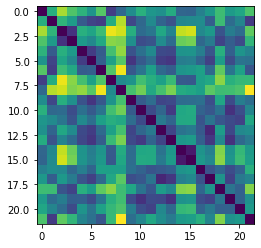

In [15]:
plt.figure()
plt.imshow(dist_pairwise);

We try a agglomerative hierarchical clustering to investigate if we can cluster in the Kendall shape space.

In [16]:
from geomstats.learning.agglomerative_hierarchical_clustering import (
    AgglomerativeHierarchicalClustering,
)

clustering = AgglomerativeHierarchicalClustering(distance="precomputed", n_clusters=2)
clustering.fit(dist_pairwise)
predicted_labels = clustering.labels_

print("True labels:", labels)
print("Predicted labels:", predicted_labels)

accuracy = gs.sum(labels == predicted_labels) / len(labels)
print(f"Accuracy: {accuracy:.2f}")

True labels: [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
Predicted labels: [0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1]
Accuracy: 0.55


The accuracy is barely above the accuracy of a random classifier, that would assign 0 or 1 with probably 0.5 to each of the shapes. This confirms that the difference that exists between the two groups is mostly due to the landmarks' set size and not their shapes.

## References

.. [PE2015] Patrangenaru and L. Ellingson. Nonparametric Statistics on Manifolds and Their Applications to Object Data, 2015. https://doi.org/10.1201/b18969